In [1]:
# Common packages
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from importlib import reload 
import pickle 
from scipy import stats
from statannotations.Annotator import Annotator

In [2]:
from collections import Counter
from itertools import combinations

In [3]:
sns.set_context("paper",font_scale=2, rc={"lines.linewidth":2})
sns.set_theme(style="ticks", color_codes=True)
sns.set_style("white")

In [4]:
import matplotlib as mpl

In [5]:
mpl.rcParams['pdf.fonttype'] = 42

In [6]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [7]:
# Read in the quads
# Read in the final trios 
quad = pd.read_csv('scTRIP_final_tiro_merged.csv')
quad = quad.drop_duplicates()

In [8]:
# Read in the clones 
clones = pd.read_csv('220404_cell_clone_info_single.csv')

In [9]:
# Read in the barcodes in clones
tBC_clones = pd.read_csv('20220404_trip_clones.tsv', sep='\t')

In [10]:
# Choose the clones that have more than 1 tBCs
clone_list = tBC_clones.clone.to_list()
clone_list = Counter(clone_list)
m_clones = [k for k, v in clone_list.items() if v > 1]
tBC_m_clones = tBC_clones.loc[tBC_clones.clone.isin(m_clones)]

In [11]:
quad_with_rep = quad

In [12]:
# Storing the pair tBC expression per cell
pairs = []
total_reads = len(quad)
for clone in m_clones:
    # Subset the cells 
    cell_list = clones.loc[clones.clone == clone].cellBC.to_list()
    test_quad = quad.loc[quad.cellBC.isin(cell_list)]
    test_tBC = tBC_m_clones.loc[tBC_m_clones.clone == clone].tBC.to_list()
    test_quad_filtered = test_quad.loc[test_quad.tBC.isin(test_tBC)]
    # Now we iterate through the cells to get all the pair
    for cell in cell_list:
        # Per cell tBC expression
        cell_slice = test_quad_filtered.loc[test_quad_filtered.cellBC == cell]
        norm_factor = len(cell_slice)/total_reads
        single_exp = []
        for tBC in test_tBC:
            slice_tBC = cell_slice.loc[cell_slice.tBC == tBC]
            if len(slice_tBC) > 0:
                single_exp.append(len(slice_tBC)*norm_factor)
            else:
                single_exp.append(0)
        combo = list(combinations(single_exp, 2))
        pairs.extend(combo)

In [13]:
pairs_nd = np.asarray(pairs)

In [14]:
len(pairs_nd[:,1])

775588

In [41]:
# It is rather impossible to plot the whole list of 0.7M points with a kde plot. In fact it kilsl the ipynb session
# I have to subsample the 
sub_pairs_nd = pairs_nd[np.random.choice(pairs_nd.shape[0], 5000, replace=False), :]

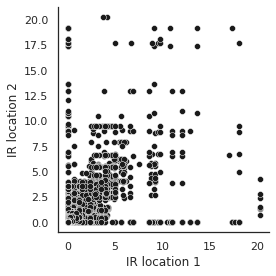

In [43]:
fig, ax = plt.subplots(figsize = (4,4))
sns.scatterplot(ax = ax, x = pairs_nd[:,1], y = pairs_nd[:,0], color = 'k')
#sns.kdeplot(ax = ax, x = sub_pairs_nd[:,1], y = sub_pairs_nd[:,0])
sns.despine()
plt.xlabel('IR location 1')
plt.ylabel('IR location 2') 
#plt.xscale('log',base = 2)
#plt.yscale('log', base = 2)
plt.tight_layout()
#plt.savefig('220522_overall_per_cell.png',dpi = 300)
#plt.show()

In [44]:
def int_noise(array):
    list_1 = array[:,0]
    list_2 = array[:,1]
    sum = 0
    # length of the vector
    n = len(list_1)
    # Calculating the correlatin of two vectorsq
    corr_matrix = np.corrcoef(list_1,list_2)
    rho = corr_matrix[0,1]
    # update rho
    rho = rho/(np.std(list_1)*np.std(list_2))
    # Get unbiased a
    a = (2*n**3 - 7*n + 6)/(2*(n**2 - n)) + ((2-n)*rho)/((n**2-n)*(1-rho)) + 1/(2*(n**2-n))*(rho/(1-rho))**2
    for i, j in zip(list_1,list_2):
        sum += (i-j)**2
    int_noise_value = 1/(2*a)*(sum - n*(np.mean(list_1) - np.mean(list_2))**2)
    return int_noise_value

In [45]:
def ext_noise(array):
    list_1 = array[:,0]
    list_2 = array[:,1]
    # length of the vector
    n = len(list_1)
    # Calculating the correlatin of two vectorsq
    corr_matrix = np.corrcoef(list_1,list_2)
    rho = corr_matrix[0,1]
    rho = rho/(np.std(list_1)*np.std(list_2))
    # Get unbiased a
    a = (n-1)*(1 + 1/n) + 1/(rho**2)
    sum = 0
    for i, j in zip(list_1,list_2):
        sum += i*j
    ext_noise_value = (sum- n*np.mean(list_1)*np.mean(list_2))/a
    return ext_noise_value

In [16]:
quad_with_rep[['cellBC', 'rep']] = quad.cellBC.str.split('-', expand = True)

In [35]:
clones_with_rep = clones
clones_with_rep[['cellBC', 'rep']] = clones.cellBC.str.split('-', expand = True)

In [36]:
# Storing the pair tBC expression per cell
pairs_rep1 = []
quad_rep1 = quad_with_rep.loc[quad_with_rep.rep == '1']
total_reads = len(quad_rep1)
clones_rep1 = clones_with_rep.loc[clones_with_rep.rep == '1']
for clone in m_clones:
    # Subset the cells 
    cell_list = clones_rep1.loc[clones_rep1.clone == clone].cellBC.to_list()
    test_quad = quad_rep1.loc[quad_rep1.cellBC.isin(cell_list)]
    test_tBC = tBC_m_clones.loc[tBC_m_clones.clone == clone].tBC.to_list()
    test_quad_filtered = test_quad.loc[test_quad.tBC.isin(test_tBC)]
    # Now we iterate through the cells to get all the pair
    for cell in cell_list:
        # Per cell tBC expression
        cell_slice = test_quad_filtered.loc[test_quad_filtered.cellBC == cell]
        norm_factor = len(cell_slice)/total_reads
        single_exp = []
        for tBC in test_tBC:
            slice_tBC = cell_slice.loc[cell_slice.tBC == tBC]
            if len(slice_tBC) > 0:
                single_exp.append(len(slice_tBC)*norm_factor)
            else:
                single_exp.append(0)
        combo = list(combinations(single_exp, 2))
        pairs_rep1.extend(combo)

In [37]:
pairs_rep2 = []
quad_rep2 = quad_with_rep.loc[quad_with_rep.rep == '2']
total_reads = len(quad_rep2)
clones_rep2 = clones_with_rep.loc[clones_with_rep.rep == '2']
for clone in m_clones:
    # Subset the cells 
    cell_list = clones_rep2.loc[clones_rep2.clone == clone].cellBC.to_list()
    test_quad = quad_rep2.loc[quad_rep2.cellBC.isin(cell_list)]
    test_tBC = tBC_m_clones.loc[tBC_m_clones.clone == clone].tBC.to_list()
    test_quad_filtered = test_quad.loc[test_quad.tBC.isin(test_tBC)]
    # Now we iterate through the cells to get all the pair
    for cell in cell_list:
        # Per cell tBC expression
        cell_slice = test_quad_filtered.loc[test_quad_filtered.cellBC == cell]
        norm_factor = len(cell_slice)/total_reads
        single_exp = []
        for tBC in test_tBC:
            slice_tBC = cell_slice.loc[cell_slice.tBC == tBC]
            if len(slice_tBC) > 0:
                single_exp.append(len(slice_tBC)*norm_factor)
            else:
                single_exp.append(0)
        combo = list(combinations(single_exp, 2))
        pairs_rep2.extend(combo)

In [38]:
pairs_rep1 = np.array(pairs_rep1)
pairs_rep2 = np.array(pairs_rep2)

In [47]:
pairs_rep2

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.00015943, 0.00018396],
       [0.00016425, 0.0001095 ],
       [0.00029872, 0.0001222 ]])

In [40]:
int_noise_rep1 = int_noise(pairs_rep1)
int_noise_rep2 = int_noise(pairs_rep2)
ext_noise_rep1 = ext_noise(pairs_rep1)
ext_noise_rep2 = ext_noise(pairs_rep2)

In [41]:
total_noise_rep1 = int_noise_rep1 + ext_noise_rep1
total_noise_rep2 = int_noise_rep2 + ext_noise_rep2

In [66]:
noise_list = [[int_noise_rep1/total_noise_rep1, 'int' ,'rep1'],
              [ext_noise_rep1/total_noise_rep1, 'ext', 'rep1'],
              [int_noise_rep2/total_noise_rep2, 'int', 'rep2'],
             [ext_noise_rep2/total_noise_rep2, 'ext', 'rep2']]

In [67]:
noise_df = pd.DataFrame(noise_list, columns = ['prop', 'type',  'rep'])

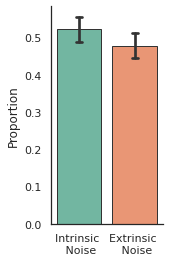

In [87]:
fig, ax = plt.subplots(figsize = (2,4))
sns.barplot(ax = ax, x = 'type', y = 'prop', data = noise_df,capsize=.1, errcolor=".2", edgecolor=".2", palette = 'Set2')
sns.despine()
ax.set_xticklabels(['Intrinsic \n Noise', 'Extrinsic \n Noise'])
plt.ylabel('Proportion')
plt.xlabel('')
#plt.savefig('220525_int_ext_noise.pdf', dpi = 300)


### Per Trip

In [46]:
# Test case
test_clone = 'clone1'
cell_list = clones.loc[clones.clone == test_clone].cellBC.to_list()

In [47]:
len(tBC_m_clones.clone.unique())

45

In [50]:
def compute_per_cell_std(test_clone, tBC_m_clones,clones, quad):
    cell_list = clones.loc[clones.clone == test_clone].cellBC.to_list()
    test_quad = quad.loc[quad.cellBC.isin(cell_list)]
    test_tBC = tBC_m_clones.loc[tBC_m_clones.clone == test_clone].tBC.to_list()
    test_quad_filtered = test_quad.loc[test_quad.tBC.isin(test_tBC)]
    # Get the per cell mean variance 
    cell_list = test_quad_filtered.cellBC.unique()
    pop_df = []
    total_reads = len(quad)
    for cell in cell_list:
        cell_slice = test_quad_filtered.loc[test_quad_filtered.cellBC == cell]
        norm_factor = len(cell_slice)/len(quad)
        tBC_list_per_cell = cell_slice.tBC.unique()
        exp_list = []
        for tBC in tBC_list_per_cell:
            exp = len(cell_slice.loc[cell_slice.tBC == tBC])*norm_factor*100
            #exp = len(cell_slice.loc[cell_slice.tBC == tBC])
            exp_list.append(exp)
        if len(exp_list) > 1:
            pop_df.append([np.mean(exp_list), np.std(exp_list), len(exp_list), test_clone, 'exp'])
    pop_df = pd.DataFrame(pop_df, columns=['mean', 'std', 'per_try', 'clone', 'type']) 
    # Get random_list
    # Now we look at the ranodm case
    num_try = len(pop_df)
    per_try_list = pop_df.per_try.to_list()
    tBC_list = list(test_quad_filtered.tBC.unique())
    pop_df_rand = []
    total_reads = len(quad)
    for i in range(num_try):
        num_sampling = per_try_list[i]
        sampling_list = random.sample(tBC_list, num_sampling)
        exp_list = []
        for sample_tBC in sampling_list:
            sample_slice = test_quad_filtered.loc[test_quad_filtered.tBC == sample_tBC]
            cell_list = list(sample_slice.cellBC.unique())
            cellBC = random.sample(cell_list,1)[0]
            sample_cell_slice = sample_slice[sample_slice.cellBC == cellBC]
            exp = len(sample_cell_slice.loc[sample_cell_slice.tBC == sample_tBC])*(len(test_quad_filtered.loc[test_quad_filtered.cellBC == cellBC])/total_reads)*100
            #exp = len(sample_cell_slice.loc[sample_cell_slice.tBC == sample_tBC])
            exp_list.append(exp)
        if len(exp_list) > 1:
            #dist_list = assign_quantile(exp_list)
            pop_df_rand.append([np.mean(exp_list), np.std(exp_list),len(exp_list), test_clone, 'control'])
    pop_df_rand = pd.DataFrame(pop_df_rand, columns=['mean', 'std', 'per_try', 'clone','type'])
    final_df = pd.concat([pop_df, pop_df_rand])
    return final_df

In [51]:
test_clone = compute_per_cell_std('clone1', tBC_m_clones,clones, quad)

In [52]:
test_clone

,mean,std,per_try,clone,type
0,1.903793,1.030474,3,clone1,exp
1,1.410781,0.379935,3,clone1,exp
2,0.451665,0.035076,3,clone1,exp
3,0.003262,0.001727,2,clone1,exp
4,0.026193,0.012510,3,clone1,exp
...,...,...,...,...,...
132,0.315424,0.433564,3,clone1,control
133,1.300470,1.800407,3,clone1,control
134,5.116590,7.136217,3,clone1,control
135,1.399916,0.614392,2,clone1,control


<AxesSubplot:xlabel='mean', ylabel='std'>

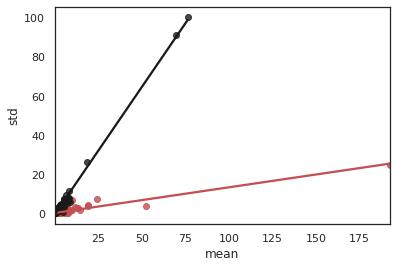

In [53]:
sns.regplot(x = 'mean', y = 'std', color = 'r', data = test_clone.loc[test_clone['type'] == 'exp'], ci=None)
sns.regplot(x = 'mean', y = 'std', color = 'k', data = test_clone.loc[test_clone['type'] == 'control'], ci=None)
#plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:xlabel='type', ylabel='std'>

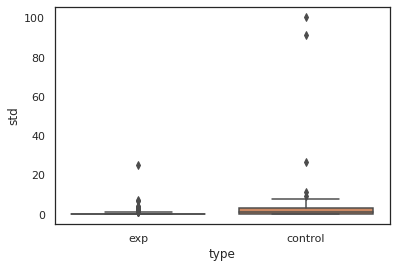

In [54]:
sns.boxplot(x = 'type', y = 'std', data = test_clone)

In [55]:
pop_df = pd.DataFrame(columns=['mean', 'std', 'per_try', 'clone','type'] )
for clone in tBC_m_clones.clone.unique():
    print(clone)
    test_df = compute_per_cell_std(clone, tBC_m_clones,clones, quad)
    pop_df = pd.concat([pop_df,test_df])
    print(len(pop_df))

clone0


KeyboardInterrupt: 

In [401]:
#pop_df.to_csv('220522_distribution_compare.csv')

In [56]:
distribution_compare_df = pd.read_csv('220522_distribution_compare.csv')

In [57]:
distribution_compare_df

,Unnamed: 0,mean,std,per_try,clone,type
0,0,0.001366,0.000372,2,clone0,exp
1,1,40.273822,28.053618,12,clone0,exp
2,2,0.341429,0.203631,5,clone0,exp
3,3,0.010133,0.004386,10,clone0,exp
4,4,0.001693,0.000479,3,clone0,exp
...,...,...,...,...,...,...
16525,58,0.004481,0.001749,2,clone180,control
16526,59,0.024289,0.021174,2,clone180,control
16527,60,0.017382,0.016479,2,clone180,control
16528,61,0.009695,0.008251,2,clone180,control


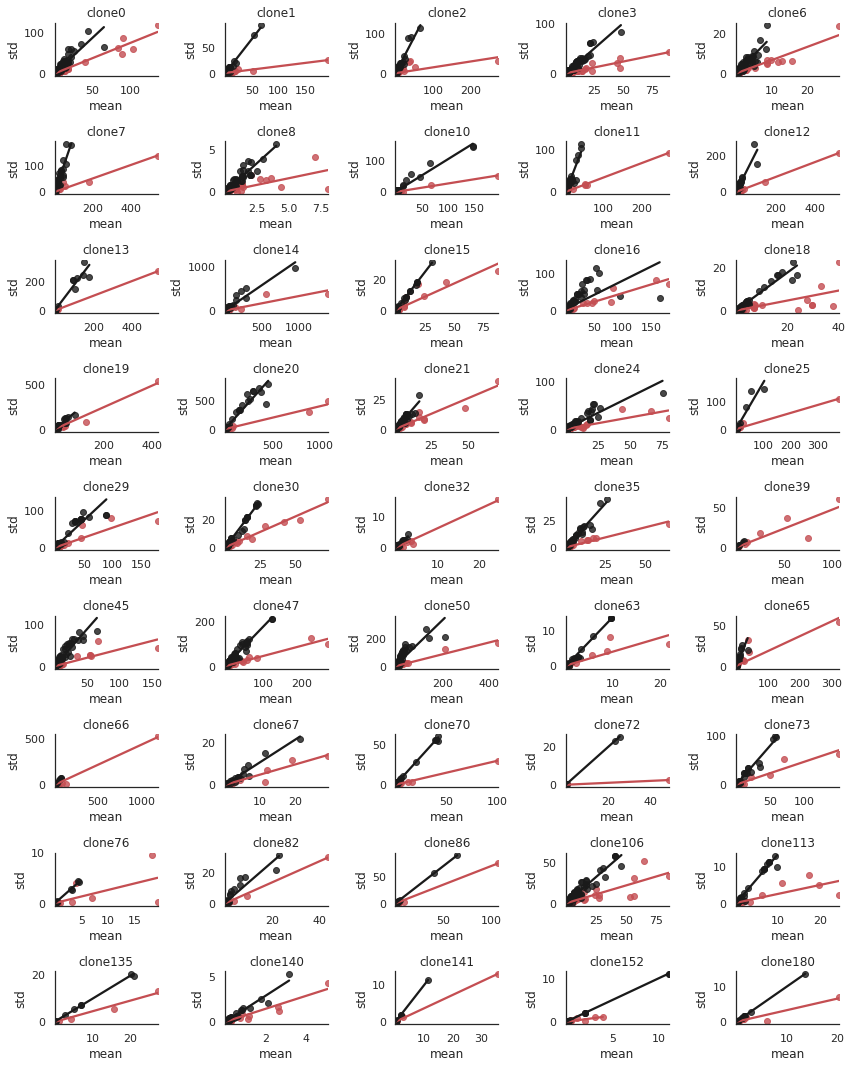

In [66]:
clone_list = distribution_compare_df.clone.unique()
Tot = len(clone_list)
Cols = 5
# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
fig, axs = plt.subplots(Rows, Cols, figsize = (12, 15), sharex=False, sharey=False)
for i, ax in enumerate(axs.flat):
    if i < len(clone_list):
        clone = clone_list[i]
        test_clone = distribution_compare_df.loc[distribution_compare_df.clone == clone]
        sns.regplot(ax = ax, x = 'mean', y = 'std', color = 'r', data = test_clone.loc[test_clone['type'] == 'exp'], ci=None)    # Or whatever you want in the subplot
        sns.regplot(ax = ax, x = 'mean', y = 'std', color = 'k', data = test_clone.loc[test_clone['type'] == 'control'], ci=None)
        sns.despine()
        #ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        #ax.set_ylabel('')
        #ax.set_xlabel('')
        ax.set_title(f'{clone}')
plt.tight_layout()
#plt.savefig('220705_std_clone.pdf', dpi = 300)
plt.show()